### Neural Graph Revealers for recovering conditional independence graphs 

- We design a synthetic experiment to study the capability of `Neural Graph Revealers` to recover conditional independence graph represented by Gaussian graphical models.  
- The input data X is sampled from a multivariate Gaussian distribution where we define the underlying precision matrix.   
- Run `NGRs` to recover the underlying graph between features that should ideally match the CI graph.

In [3]:
import os, sys
# reloads modules automatically before entering the 
# execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2
print(sys.prefix)
import warnings
warnings.filterwarnings('ignore')

import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/anaconda/envs/ngm


### Setup the Gaussian graphical model
1. Initialize a graph type.
2. Get the precision matrix `theta` and corresponding samples `X` from a multivariate Gaussian distribution.
3. Get the partial correlations matrix `rho` and the graph `G`.

In [111]:
import numpy as np
import pandas as pd

# Local imports
from ngr.utils import ggm
from ngr.utils import data_processing as dp
# from uGLAD.utils.metrics import reportMetrics

# Xb = samples batch, trueTheta = corresponding true precision matrices
Xb, true_theta = ggm.get_data(
    num_nodes=10, 
    typeG='CHAIN', 
    sparsity=[0.2, 0.2], # Not used for chain graph
    num_samples=5000, 
    batch_size=1,
    eig_offset=0.1, # 0.5 #0.1, 
    w_min=0.5,
    w_max=1
)
X, true_theta =Xb[0], true_theta[0]
# set the column names for X
X = pd.DataFrame(X, columns=['n'+str(i) for i in range(X.shape[1])])
rho = ggm.get_partial_correlations(true_theta)
print(f'partial correlations: {rho.shape}, Samples {X.shape}')
G, image_G, graph_edge_list = ggm.graph_from_partial_correlations(rho, X.columns)

partial correlations: (10, 10), Samples (5000, 10)
Sparsity 1 using threshold 0.0


In [112]:
Gv = dp.get_interactive_graph(G, 'GGM Chain graph', node_PREFIX=None)
Gv.show('viz_ggm.html')

In [113]:
X

,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9
0,0.927876,0.258931,-0.105842,-0.678787,-0.745415,1.236235,-0.282876,0.281102,-0.583366,1.131229
1,-0.570216,-0.263540,-0.755614,0.527412,0.567624,-0.080773,0.654520,-0.984607,2.032298,0.060092
2,-0.389144,1.417749,-2.916772,-1.309015,-0.184877,0.481146,-0.672332,0.094541,-0.612361,0.075920
3,2.594957,-1.229257,1.749264,1.898640,1.691540,-1.521940,1.720549,0.378290,-0.644375,0.785154
4,0.621426,-0.129744,-0.404810,1.775537,1.637809,-4.875077,3.339646,1.970880,0.021086,-0.343922
...,...,...,...,...,...,...,...,...,...,...
4995,0.046404,0.881449,-0.097669,-0.415455,-1.273092,1.486392,-0.373307,-0.769104,1.038608,-0.769487
4996,1.592964,-1.186895,2.800115,1.931809,2.167905,-1.118636,1.883468,0.953308,0.101772,0.109246
4997,-1.415726,0.487105,1.369036,2.707052,1.731495,-1.835650,0.594205,0.444833,0.549311,-0.234094
4998,0.041689,0.456697,0.112964,-0.716785,-1.153483,-0.461233,0.976402,1.339956,-0.549866,-1.130835


### Setup DAG input data

- Moralize the DAG graph to get the undirected version

In [332]:
# Local imports
from ngr.utils import dag
from ngr.utils import data_processing as dp
import networkx as nx
import numpy as np
import pandas as pd


# Do we need to moralize the DAG?
def get_DAG_data():
    dag.set_random_seed(1)
    # s0 = expected edges
    n, d, s0, graph_type, sem_type = 1000, 10, 10, 'ER', 'gauss'
    B_true = dag.simulate_dag(d, s0, graph_type)
    W_true = dag.simulate_parameter(B_true)
    node_names = ['n'+str(i) for i in range(W_true.shape[0])]
    W_true = pd.DataFrame(W_true, columns=node_names, index=node_names)
    print(W_true)
    # np.savetxt('W_true.csv', W_true, delimiter=',')
    X = dag.simulate_linear_sem(W_true, n, sem_type)
    print(B_true.shape, W_true, X,  X.shape)
    # Moralize the W_true
    G_BN = nx.from_pandas_adjacency(W_true, create_using=nx.DiGraph)
    G_BN_moral = nx.moral_graph(G_BN)
    return X, G_BN_moral

X, G = get_DAG_data()
Gv = dp.get_interactive_graph(G, 'Moralized DAG graph', node_PREFIX=None)
Gv.show('viz_dag_moralized.html')

          n0       n1        n2        n3        n4        n5   n6   n7   n8  \
n0  0.000000  0.00000  0.000000  0.000000  0.000000  1.643860  0.0  0.0  0.0   
n1  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.0   
n2  0.000000  0.00000  0.000000  0.000000  0.000000 -1.252836  0.0  0.0  0.0   
n3  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.0   
n4  0.000000  0.00000  0.000000  0.000000  0.000000 -1.173013  0.0  0.0  0.0   
n5  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.0   
n6  0.000000  0.00000  0.000000  0.000000 -1.582522  0.535826  0.0  0.0  0.0   
n7  0.000000 -1.56536  0.970416  1.929247  0.000000  0.000000  0.0  0.0  0.0   
n8 -0.594215  0.00000  0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.0   
n9  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.0   

          n9  
n0  0.000000  
n1  0.000000  
n2  0.000000  
n3  0.000000  
n4  0.000000  
n5  0.000000  
n6  0.000000  

In [333]:
X

,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9
0,-0.879388,-1.498487,-0.200611,-0.565441,0.749589,-4.111331,-0.236126,0.258645,1.514419,-2.066371
1,0.209718,0.013761,-0.816109,-1.839567,2.329623,-2.117465,-1.706715,-0.430337,-0.043701,-0.100583
2,0.370812,-0.784018,-1.006298,-3.390591,3.055930,-0.894312,-1.277711,-0.398817,-1.267784,3.543143
3,-0.203842,2.331434,-2.148552,-2.014193,0.468403,0.784667,-0.689479,-1.256842,-0.195800,0.972099
4,1.152455,-0.286871,0.166349,-0.525902,1.741010,-1.383982,0.028191,-0.637556,-1.198330,2.015815
...,...,...,...,...,...,...,...,...,...,...
995,-1.174983,1.436450,-2.772480,-2.178824,2.852591,-3.176169,-2.162356,-0.786797,0.536955,-0.134556
996,1.465461,0.761249,-2.022885,-1.293409,3.827028,-0.699275,-1.287469,-0.488268,-1.457896,3.446737
997,1.092442,1.026486,1.927907,0.707301,-3.192190,2.972836,1.645823,0.359245,-1.112489,1.395480
998,-1.174755,-0.174931,-0.541422,-0.801369,-1.985708,1.058453,1.227950,-0.177895,-0.714533,1.086326


### Neural graph revealer

For faster runtimes, set USE_CUDA=True

In [352]:
import pandas as pd
import ngr.main as ngr
import ngr.utils.data_processing as dp

# Learning the NGR model, works with no log scaling forward NGM
# model_NGR = ngr.recover_graph(
#     X, lambd=1e2,
#     hidden_dim=100,
#     epochs=50000, 
#     lr=0.0005, #0.0005,
#     norm_type='min_max',
#     k_fold=1,
#     structure_penalty='hadamard',
#     VERBOSE=True, 
#     BATCH_SIZE=None#5000, #1000
# ) 
model_NGR = ngr.recover_graph(
    X, lambd=1e2,
    hidden_dim=100,
    epochs=40000, 
    lr=0.0003, #0.0005,
    norm_type='min_max',
    k_fold=1,
    structure_penalty='hadamard',
    VERBOSE=True, 
    BATCH_SIZE=None#5000, #1000
) 
# NOTE 
# Divide into batches
# Stop training when train & test loss are low and the values are comparable. 
# Focus on structure loss, it becomes constant after certain iterations and then focus on regression starts... 
# Maybe adjust lambda to fit the regression first and then narrow down the structure?

Means of selected features (n0   -0.029633
n1   -0.062458
n2    0.024589
n3    0.075272
n4    0.005664
n5   -0.088981
n6    0.010743
n7    0.031819
n8    0.031036
n9   -0.019124
dtype: float64, 10)
Normalizing the data: min_max
: Processing the input table for basic compatibility check
: The input table has sample 1000 and features 10
: Total zero samples dropped 0
: Single value columns dropped: total 0, columns []
: The processed table has sample 1000 and features 10
: Total time to process the table 0.008 secs
Fold num 0
Initializing the NGM model

Fold 0: epoch:0/40000
Train: loss=3.927712917327881, reg=0.28683754801750183, struct=0.03640875220298767
Test: loss=3.9299302101135254, reg=0.2890547811985016, struct=0.03640875220298767

Fold 0: epoch:4000/40000
Train: loss=2.202124834060669, reg=0.019023168832063675, struct=0.02183101698756218
Test: loss=2.2025718688964844, reg=0.019470108672976494, struct=0.02183101698756218

Fold 0: epoch:8000/40000
Train: loss=1.4194153547286987, reg

In [353]:
import networkx as nx
# Plot the graph
def adjust_graph_sparsity(G_in, sparsity=1, roundOFF=4):
    G = nx.Graph() # G_out 
    names = np.array(G_in.nodes())
    G.add_nodes_from(names)
    rho = np.array(nx.adjacency_matrix(G_in).todense())
    D = rho.shape[-1]
    
    # determining the threshold to maintain the sparsity level of the graph
    def upper_tri_indexing(A):
        m = A.shape[0]
        r,c = np.triu_indices(m,1)
        return A[r,c]

    rho_upper = upper_tri_indexing(np.abs(rho))
    num_non_zeros = int(sparsity*len(rho_upper))
    rho_upper.sort()
    th = rho_upper[-num_non_zeros]
    print(f'Sparsity {sparsity} using threshold {th}')
    th_pos, th_neg = th, -1*th

    for i in range(D):
        for j in range(i+1, D):
            if rho[i,j] > th_pos:
                G.add_edge(names[i], names[j], color='green', weight=round(rho[i,j], roundOFF), label='+')
            elif rho[i,j] < th_neg:
                G.add_edge(names[i], names[j], color='red', weight=round(rho[i,j], roundOFF), label='-')
    return G

def get_graph_NGR(model_NGR, sparsity=1):
    model, scaler, feature_means = model_NGR
    # Get the dependency matrix
    prod_W = dp.t2np(ngr.product_weights_MLP(model))
    print(f'Diagonals should be low {prod_W}')
    
    # Get the adjacency matrix (symmetric)
    adj = (prod_W + np.transpose(prod_W))/2.0
    # adj = np.linalg.inv(adj)
    # print(f'inv of adj {np.linalg.inv(adj)}')
    print(f'ADJ {adj}')
    # adj=prod_W
    G = nx.from_numpy_matrix(adj)
    # add node names
    mapping = {i:f for i, f in enumerate(feature_means.index)}
    G = nx.relabel_nodes(G, mapping)
    # adjust sparsity
    G = adjust_graph_sparsity(G, sparsity=sparsity)
    return G
G_ngr = get_graph_NGR(model_NGR)
print(G_ngr.edges(data=True))
Gv_ngr = dp.get_interactive_graph(G_ngr, 'NGR graph', node_PREFIX=None)
Gv_ngr.show('viz_ngr.html')

Diagonals should be low [[2.65909446e-04 4.51260450e-04 9.99995708e-01 1.83513388e-04
  7.66133744e-05 2.51252647e-03 1.21856741e-04 8.59170468e-05
  2.19091264e-04 1.40086538e-03]
 [1.05626299e-03 2.69018696e-04 3.64759471e-03 4.52617824e-04
  1.66849713e-04 4.74529545e-04 1.68942890e-04 9.99992371e-01
  2.18374829e-04 4.19904594e-04]
 [2.59443710e-04 1.44232676e-04 2.17761422e-04 4.08108492e-04
  9.83471109e-05 2.29680954e-04 9.99999821e-01 8.42554655e-05
  9.68461754e-05 1.93430329e-04]
 [2.51282152e-04 1.78114758e-04 1.00017828e-03 2.85194896e-04
  1.18394615e-04 2.42098336e-04 1.13880051e-04 1.64558805e-04
  1.60351861e-04 9.99999344e-01]
 [3.60924285e-04 1.75509296e-04 1.49774889e-04 9.99984980e-01
  1.43302794e-04 2.93410243e-03 4.60554706e-03 1.63692384e-04
  1.88305799e-04 2.36906912e-04]
 [9.99998868e-01 1.26359417e-04 1.23233505e-04 1.37218914e-04
  1.28367610e-04 2.68582604e-04 1.52146351e-03 7.38490271e-05
  1.11845213e-04 5.62174428e-05]
 [5.65043243e-04 2.29459474e-04 1.

### Comparison 

In [354]:
# Solving using the DAG solver
def dag_solver(X):
    node_names = X.columns
    W_est = dag.notears_linear(np.array(X), lambda1=0.1, loss_type='l2')
    W_est = pd.DataFrame(W_est, columns=node_names, index=node_names)
    G = nx.from_pandas_adjacency(W_est,create_using=nx.DiGraph())
    # moralize the graph 
    G_moral = nx.moral_graph(G)
    return G_moral
    
G_dag_solver = dag_solver(X)

In [355]:
# Comparing with true precision matrix
from ngr.utils.metrics import graph_compare_metrics

true_adj = np.array(nx.adjacency_matrix(G).todense())
ngr_adj = np.array(nx.adjacency_matrix(G_ngr).todense())
compare_results = graph_compare_metrics(
    (true_adj != 0).astype(int),# np.abs(true_adj), 
    np.abs(ngr_adj) # Compare with sparsity=1
)
print(f'NGR: {compare_results}')
dag_adj = np.array(nx.adjacency_matrix(G_dag_solver).todense())
compare_results = graph_compare_metrics(
    (true_adj != 0).astype(int),# np.abs(true_adj), 
    np.abs(dag_adj) # Compare with sparsity=1
)
print(f'DAG solver: {compare_results}')

NGR: {'FDR': 0.6590909090909091, 'TPR': 1.0, 'FPR': 0.9666666666666667, 'SHD': 29, 'nnzTrue': 15, 'nnzPred': 44, 'precision': 0.3409090909090909, 'recall': 1.0, 'Fbeta': 0.5084745762711864, 'aupr': 0.7056306873953933, 'auc': 0.8044444444444445}
DAG solver: {'FDR': 0.0, 'TPR': 1.0, 'FPR': 0.0, 'SHD': 0, 'nnzTrue': 15, 'nnzPred': 15, 'precision': 1.0, 'recall': 1.0, 'Fbeta': 1.0, 'aupr': 1.0, 'auc': 1.0}


In [356]:
true_adj, ngr_adj

(array([[ 0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
          1.6438597 ,  1.        ,  0.        , -0.59421451,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        , -1.56536   ,  0.        ,  0.        ],
        [ 1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         -1.2528364 ,  1.        ,  0.97041624,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  1.92924669,  0.        ,  0.        ],
        [ 1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         -1.17301259, -1.58252174,  0.        ,  0.        ,  0.        ],
        [ 1.6438597 ,  0.        , -1.2528364 ,  0.        , -1.17301259,
          0.        ,  0.53582614,  0.        ,  0.        ,  0.        ],
        [ 1.        ,  0.        ,  1.        ,  0.        , -1.58252174,
          0.53582614,  0.       

In [357]:
true_theta

array([[ 1.67519542,  0.7765943 ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.7765943 ,  1.67519542,  0.78281713,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.78281713,  1.67519542, -0.91296243,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.91296243,  1.67519542, -0.64178659,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.64178659,  1.67519542,
         0.94261612,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.94261612,
         1.67519542,  0.91647203,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.91647203,  1.67519542, -0.70265772

### Params to vary  
USE FROBENIUS NORM  
ADD soft-symmetry term in draft  
1. Different lambda for structure loss l1 & diag  
2. Neural network num layers, dimensions, initializations  
3. learning rate, early stopping  
4. Try DAG data instead of GGM. Add the GGM results as under investigation  

#### GGM
Can be shown analytically 

Features dropped from graph: set()
target=n1, source=n7


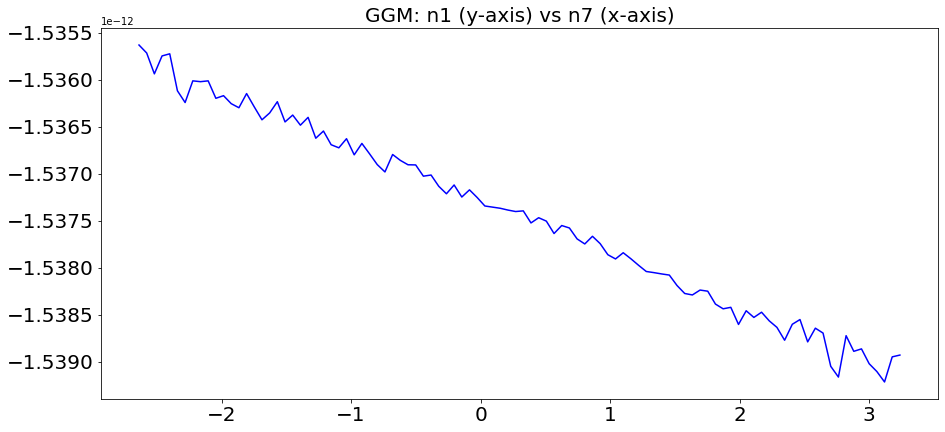

In [358]:
# Local imports
from ngr.utils import ggm

# Define the mean and cov of the multivariate Gaussian
data_min_ = X.min(axis=0)
data_max_ = X.max(axis=0)
_scaler = [data_min_, data_max_]
D = true_theta.shape[0]
mean = pd.Series(np.zeros(D), index=X.columns)
cov=np.linalg.pinv(true_theta)
feature_of_interest = 'n1'
# Analyse the feature dependency functions
ggm.analyse_feature(feature_of_interest, [mean, cov, _scaler], G, Xi=mean)

#### NGM

Features dropped from graph: set()
target=n1, source=n7


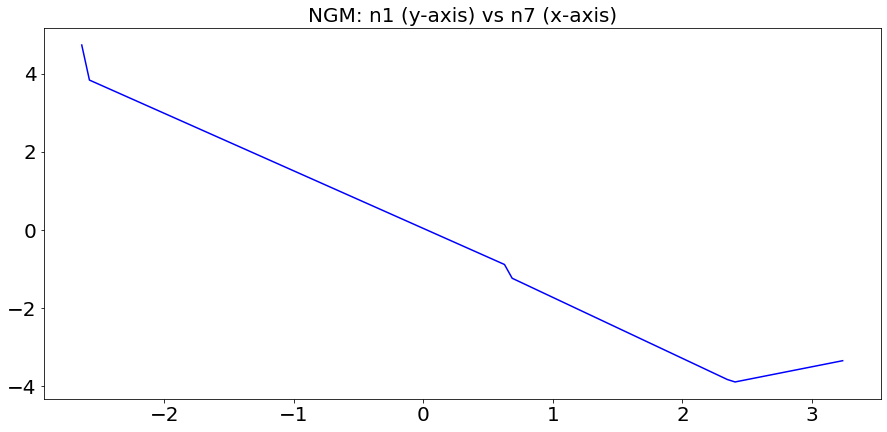

In [359]:
# Analyse the distribution details of the feature of interest
ngr.analyse_feature(feature_of_interest, model_NGR, G, dp.series2df(mean))

### NGM: Sampling

In [ ]:
import ngm.main as ngm

Xs = ngm.sampling(model_NGM, G, num_samples=4000, max_infer_itr=2)
Xs = Xs[X.columns]

### Run CI graph recovery algorithms
1. uGLAD
2. BCD

In [68]:
# uGLAD
from ngm.utils.uGLAD import main as uG
from ngm.utils.metrics import reportMetrics

# Initialize the model
model_uGLAD = uG.uGLAD_GL()  

Xs = Xs[X.columns]
# Fit to the data
model_uGLAD.fit(
    Xs,
    centered=False,
    epochs=2000,
    lr=0.001,
    INIT_DIAG=0,
    L=5,
    verbose=True, 
    k_fold=0,  # Direct mode
    mode='direct'
)  

# Comparing with true precision matrix
compare_theta_uGLAD = reportMetrics(
        true_theta, 
        model_uGLAD.precision_
    )
print(f'uGLAD: {compare_theta_uGLAD}')

Running uGLAD
Processing the input table for basic compatibility check
: Processing the input table for basic compatibility check
: The input table has sample 4000 and features 10
: Total zero samples dropped 0
: Single value columns dropped: total 0, columns []
Input covariance matrix: The condition number 1.5572058852566435 and min eig 0.006871181005512089 max eig 0.010699843500447085
: Duplicates dropped: total 0, columns []
: Low Variance columns dropped: min variance 0.0,        total 0, columns []
Processed covariance matrix: The condition number 1.5572058852566435 and min eig 0.006871181005512089 max eig 0.010699843500447085
: The processed table has sample 4000 and features 10
: Total time to process the table 0.852 secs
Direct Mode
epoch:0/2000 loss:-12.358485221862793
epoch:200/2000 loss:-15.940261840820312
epoch:400/2000 loss:-20.333969116210938
epoch:600/2000 loss:-25.18743133544922
epoch:800/2000 loss:-37.673797607421875
epoch:1000/2000 loss:-37.6756591796875
epoch:1200/20

In [82]:
def viz_graph_from_precision(theta):
    rho = ggm.get_partial_correlations(theta)
    Gr, _, _ = ggm.graph_from_partial_correlations(
        rho, 
        Xs.columns,
        sparsity=0.3
    )
    Gv = dp.get_interactive_graph(Gr, 'CI graph recovered from NGM samples', node_PREFIX=None)
    return Gv
    

In [83]:
Gv = viz_graph_from_precision(model_uGLAD.precision_)
Gv.show('viz_ggm_from_ngm_samples.html')

Sparsity 0.3 using threshold 0.05290000024270138
